In [73]:
import openjphpy as ojph
from openjphpy.backend import ProgressionOrder, Tileparts

import numpy as np
import os
import re
import matplotlib.pyplot as plt

In [96]:
def decoded_bytes(filename):
  SOT = b'\xff\x90'
  EOI = b'\xff\xd9'
  with open(filename, 'rb') as f:
    return [i.start() for i in re.finditer(b'|'.join((SOT, EOI)), f.read())][1:]
  
def subresolution(resolution, decomposition):
  x, y = resolution
  return x // 2**decomposition, y // 2**decomposition

Keys: ['arr_0', 'arr_1', 'arr_2', 'arr_3', 'arr_4']
Key selected: arr_0


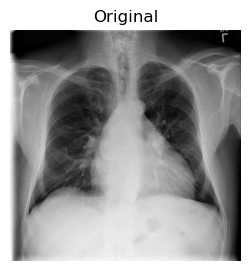

Original:
	Resolution: (1024, 1024)
	Bytes Decoded: 445.7715 KB
Decomposition 0:
	Resolution: (64, 64)
	Time Taken: 0.152 ms
	Bytes Decoded: 1.2432 KB
Decomposition 1:
	Resolution: (128, 128)
	Time Taken: 0.203 ms
	Bytes Decoded: 3.3086 KB
Decomposition 2:
	Resolution: (256, 256)
	Time Taken: 0.47 ms
	Bytes Decoded: 10.043 KB
Decomposition 3:
	Resolution: (512, 512)
	Time Taken: 1.21 ms
	Bytes Decoded: 34.1797 KB
Decomposition 4:
	Resolution: (1024, 1024)
	Time Taken: 3.957 ms
	Bytes Decoded: 126.4902 KB


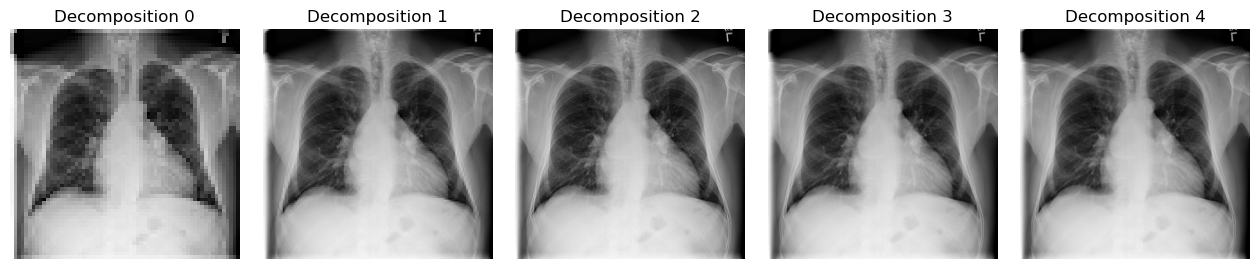

In [100]:
# Experiment with encoder parameters!
encoder_params = {
  'num_decomps' : 5,
  # 'qstep' : 0.0039,
  'reversible' : True,
  # 'color_trans' : True,
  'prog_order' : ProgressionOrder.RPCL,
  # 'block_size' : (64,64),
  # 'precints' : None,
  # 'tile_offset' : None,
  # 'tile_size' : None,
  # 'image_offset' : None,
  'tileparts' : Tileparts.R,
  'tlm_marker' : True,
}

# Both values are zero-indexed
# Dataset (0 or 1)
dataset = 1
# Image (5 images in each dataset)
key = 0

# Load dataset and print keys for each image + selected image
ds = np.load(f'../data/dataset{dataset}/data.npz')
print('Keys:', list(ds.keys()))
print('Key selected:', f'arr_{key}')

# Load image
img = ds[f'arr_{key}']
# Temporary directory
os.makedirs('../data/dataset2/encoded/', exist_ok=True)
# Encode image using parameters from above!
ojph.encode(
  filename = f'../data/dataset2/encoded/arr_{key}.jph',
  img = img,
  strict = False,
  num_decomps = encoder_params['num_decomps'],
  # qstep = encoder_params['qstep'],
  reversible = encoder_params['reversible'],
  # color_trans = encoder_params['color_trans'],
  prog_order = encoder_params['prog_order'],
  # block_size = encoder_params['block_size'],
  # precints = encoder_params['precints'],
  # tile_offset = encoder_params['tile_offset'],
  # tile_size = encoder_params['tile_size'],
  # image_offset = encoder_params['image_offset'],
  tileparts = encoder_params['tileparts'],
  tlm_marker = encoder_params['tlm_marker'],
)

# Locate tilepart markers
bytes = decoded_bytes(f'../data/dataset2/encoded/arr_{key}.jph')
  
# Display original
plt.figure(figsize=(3,3))
plt.imshow(img, cmap='gray')
plt.title(f'Original')
plt.axis('off')
plt.show()

# Original image metadata
x, y = img.shape
print(f'Original:\n\tResolution: {x,y}\n\tBytes Decoded: {round(bytes[-1]/1024, 4)} KB')

# Display decompositions with metadata
num_decomps = encoder_params['num_decomps']
fig, axes = plt.subplots(1, num_decomps, figsize=(3*num_decomps+1,3))
for i in range(num_decomps):
  dimg, dt = ojph.decode(
    f'../data/dataset2/encoded/arr_{key}.jph',
    skip_res = num_decomps-(i+1)
  )
  axes[i].imshow(dimg, cmap = 'gray')
  axes[i].axis('off')
  axes[i].set(title=f'Decomposition {i}')
  # Display bytes decoded only if tilepart markers exist
  if encoder_params['tileparts']:
    print(f'Decomposition {i}:\n\tResolution: {subresolution((x,y), num_decomps-(i+1))}\n\tTime Taken: {round(dt*1000, 4)} ms\n\tBytes Decoded: {round(bytes[i]/1024, 4)} KB')
  else:
    print(f'Decomposition {i}:\n\tResolution: {subresolution((x,y), num_decomps-(i+1))}\n\tTime Taken: {round(dt*1000, 4)} ms')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()